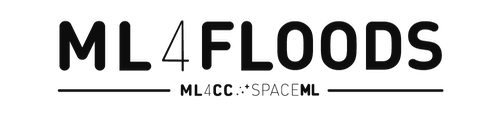

# Model Metrics

This notebook shows how to compute metrics for a trained model on the *WorldFloods* test dataset. The notebook is divided in 4 steps:

1. Load the config file of the experiment.
1. Create a dataloader for the test dataset.
1. Create the segmentation model and load their weights
1. Run inference on all images in the dataset and compute metrics

In [1]:
import sys, os
from pathlib import Path
from pyprojroot import here
# spyder up to find the root
root = here(project_files=[".here"])
# append to path
sys.path.append(str(here()))

# %load_ext autoreload
# %autoreload 2

In [2]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/opt/creds/ML4CC_creds.json"

## Step 1: Get config

In [12]:
from src.models.config_setup import get_default_config
from imp import reload

experiment_name = "WFV1_unet"
checkpoint_name = "epoch=24-step=153649.ckpt"
config_fp = f"gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart/{experiment_name}/config.json"
# config_fp = os.path.join(root, 'src', 'models', 'configurations', 'worldfloods_template.json')
config = get_default_config(config_fp)
config["model_params"]["max_tile_size"] = 1024

gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart/WFV1_unet/config.json
Loaded Config for experiment:  WFV1_unet
{   'data_params': {   'batch_size': 32,
                       'bucket_id': 'ml4floods',
                       'channel_configuration': 'all',
                       'filter_windows': False,
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 8,
                       'path_to_splits': '/worldfloods/public',
                       'target_folder': 'gt',
                       'test_transformation': {   'normalize': True,
                                                  'num_classes': 3,
                                                  'totensor': True},
                       'train_test_split_file': 'worldfloods/public/train_test_split.json',
                       'train_transformation': {   'normalize': True,
                                                   'num_classes': 3,
                

In [6]:
config["data_params"]

{'loader_type': 'local',
 'num_workers': 8,
 'filter_windows': False,
 'bucket_id': 'ml4floods',
 'path_to_splits': '/worldfloods/public',
 'train_test_split_file': 'worldfloods/public/train_test_split.json',
 'input_folder': 'S2',
 'target_folder': 'gt',
 'batch_size': 32,
 'window_size': [256, 256],
 'channel_configuration': 'all',
 'train_transformation': {'num_classes': 3,
  'totensor': True,
  'normalize': True},
 'test_transformation': {'num_classes': 3,
  'totensor': True,
  'normalize': True}}

## Step 2: Load dataloader

In [7]:
from src.models import dataset_setup

# Configure the dataset to load directly from the Google bucket
config["data_params"]["loader_type"] = "local"
config["data_params"]["path_to_splits"] = "/worldfloods/public/"

# train_transform, test_transform = dataset_setup.get_transformations(config["data_params"])

In [8]:
data_module = dataset_setup.get_dataset(config["data_params"])

Using local dataset for this run
train 196648  tiles
val 1284  tiles
test 11  tiles


In [9]:
dl = data_module.test_dataloader()
# dl = data_module.val_dataloader()

## Step 3: Load a trained model

In [13]:
from src.models.worldfloods_model import WorldFloodsModel

checkpoint_path = f"gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart/{experiment_name}/checkpoint/{checkpoint_name}"
model = WorldFloodsModel.load_from_checkpoint(checkpoint_path)

model.eval()
model.to("cuda:1")

13 3


WorldFloodsModel(
  (network): UNet(
    (dconv_down1): Sequential(
      (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), 

## Step 4: Run inference on all the images in the test dataset

In [14]:
from src.models.model_setup import get_model_inference_function
inference_function = get_model_inference_function(model, config, apply_normalization=False)

100%|██████████| 11/11 [02:30<00:00, 13.73s/it]


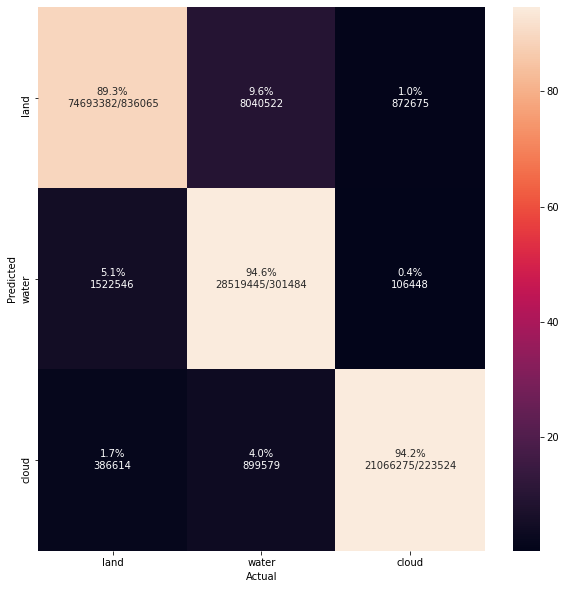

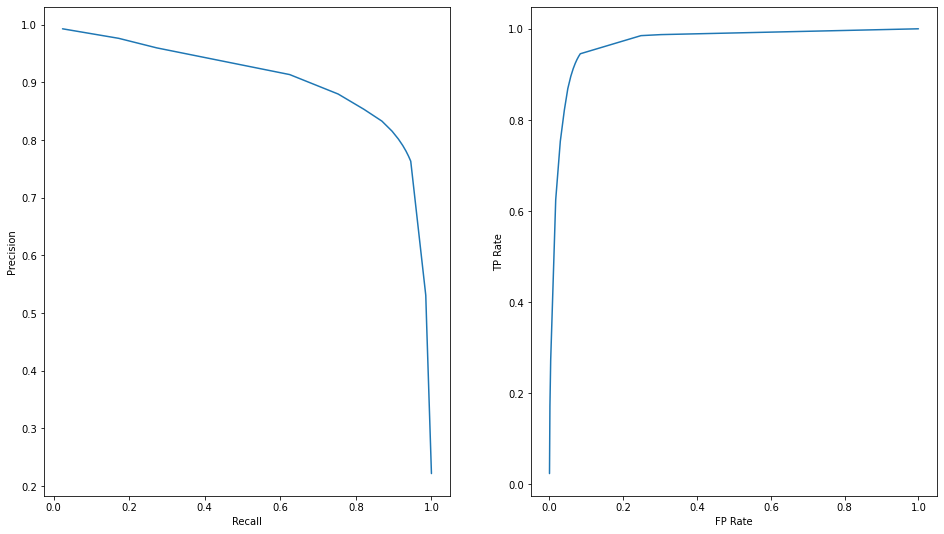

Per Class IOU {
    "cloud": 0.9029077785566316,
    "land": 0.8734460214394203,
    "water": 0.7296114155197847
}


In [15]:
import torch
import numpy as np
import pandas as pd
from src.models.utils import metrics

# Otherwise fails when reading test dataset from remote bucket
# torch.set_num_threads(1)

thresholds_water = [0,1e-3,1e-2]+np.arange(0.5,.96,.05).tolist() + [.99,.995,.999]

mets = metrics.compute_metrics(
    dl,
    inference_function, 
    config.model_params.hyperparameters.num_classes, 
    label_names=config.model_params.hyperparameters.label_names, 
    thresholds_water=thresholds_water, 
    plot=False)
metrics.plot_metrics(mets, config.model_params.hyperparameters.label_names)

## Bonus: Compute the metrics for each flood in the test dataset

In [16]:
CODES_LOC = {"EMSR333": "EMSR333 (Italy)",
             "EMSR9284": "EMSR284 (Finland)",
             "EMSR347": "EMSR347 (Malawi)",
             "EMSR286": "EMSR286 (Colombia)",
             "EMSR342": "EMSR342 (Australia)"
            }

if hasattr(dl.dataset, "image_files"):
    cems_code = [os.path.basename(f).split("_")[0] for f in dl.dataset.image_files]
else:
    cems_code = [os.path.basename(f.file_name).split("_")[0] for f in dl.dataset.list_of_windows]

iou_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_iou,
                                                    label_names=config.model_params.hyperparameters.label_names))
iou_per_code["code"] = iou_per_code["code"].apply(lambda x: CODES_LOC.get(x,x))
iou_per_code = iou_per_code.set_index("code")
iou_per_code = iou_per_code*100
print(f"Mean IoU across flood events: {iou_per_code.mean(axis=0).to_dict()}")
iou_per_code

Mean IoU across flood events: {'land': 87.7264665724063, 'water': 74.14875561083508, 'cloud': 70.01686774881253}


,land,water,cloud
code,,,
EMSR286 (Colombia),94.452269,85.104708,96.259330
EMSR333 (Italy),89.956551,59.949436,73.404743
EMSR342 (Australia),67.419744,72.314018,89.287511
EMSR347 (Malawi),96.865007,76.443802,91.132753
EMSR284 (Finland),89.938762,76.931815,0.000002
